# Visualization of Matrices and Dose-response curves

This notebooks is an example on how to use the functions to generate (1) a correlation matrix from image-based profile data, and (2) dose-response curves based on similarities between replicates or feature values.

a) We must import a image-based profile table (those can be generated using the notebooks inside the `profile` folder in this repo);

b) We generate correlation matrices to visualize the data;

## Dose-response

1) Define the negative control and positive control of your samples;

2) We must generate a dictionary (similarity between replicates of the same treatment, or the similarity of the treatments to the positive control) and organize them as x, x_log and y

3) Then we plot linear regression for visualization;

4) Finally, we calculate the EC50 from a non-linear regression function (based from [GraphPad prism function](https://www.graphpad.com/guides/prism/latest/curve-fitting/reg_ecanything.htm)).


# 1. Imports

- Please change in the below cell the path to your local directory where this repository is located:

Example `sys.path.append(r"C:\Users\USERNAME\Documents\GitHub")`

In [1]:
path = r"C:\Users\Fer\Documents\GitHub"

In [2]:
import pandas as pd
import easygui as eg
import sys

sys.path.append(path)
from scripts_notebooks_fossa.correlation_dose import dose_utils

%load_ext autoreload
%autoreload 2

## 1.1 Inputs

- Run the next cells to choose the .CSV file that contains the per-well image-based profiles;
- We will import them into a dataframe and get the name of the plates inside `Metadata_Plate` column.

In [12]:
myfile = eg.fileopenbox(msg="Choose a file", default=r"E:")
print('Filename', myfile)

Filename None


In [4]:
df = pd.read_csv(myfile)
df.head()
plates = df['Metadata_Plate'].unique()
print(plates)

['211110_120733_Plate_1' '211112_140950_Plate_1' '211117_162924_Plate_1']


## 1.2 Labels

- Run the next cells to check the columns with `Metadata` information, and choose the one's that has the information for `Compound` and `Concentration` to be joined together into a new column.

- Generate a list of compounds `list_cmp` from this new column unique values; we will use these values later.

In [5]:
#Check the names of your metadata columns
[cols for cols in df.columns if 'Metadata' in cols]

['Metadata_Plate',
 'Metadata_Well',
 'Metadata_cell_count',
 'Metadata_plate_map_name',
 'Metadata_Compound',
 'Metadata_Concentration',
 'Metadata_Concentration_unit',
 'Metadata_Cell',
 'Metadata_control_type']

In [6]:
#Select which Metadata cols to join and paste into cols_to_join
#new_col is the col name we are using later
cols_to_join = ["Metadata_Compound", "Metadata_Concentration"]
new_col = 'Cells_CompoundSizeCnc'

In [7]:
df, new_col = dose_utils.col_generator(df, cols_to_join = cols_to_join)

Concentration
Names of the compounds + concentration:  ['SLNplex 152.0' 'SLNplex 190.0' 'Non-treated 0.0' 'DMSO 10.0'
 'SLNplex 7.6' 'SLNplex 15.2' 'SLNplex 30.4' 'SLNplex 38.0' 'SLNplex 76.0'
 'SLNplex 114.0']


In [8]:
list_cmp = df[new_col].unique()
print(list_cmp)

['SLNplex 152.0' 'SLNplex 190.0' 'Non-treated 0.0' 'DMSO 10.0'
 'SLNplex 7.6' 'SLNplex 15.2' 'SLNplex 30.4' 'SLNplex 38.0' 'SLNplex 76.0'
 'SLNplex 114.0']


# 2. Correlation matrix/similarity matrix: calculate and visualize

Goal is to calculate a correlation matrix for each plate, or for all the replicates together.

How?
1) Determine a new dataframe containing only the Nuclei, Cells and Cytoplasm columns:
    
    **NOTE**: here we use the pycytominer function `pycytominer.cyto_utils.features.infer_cp_features` that will consider that you have named your feature columns with the prefixes `Nuclei_`, `Cells_`, and `Cytoplasm_`.

2) Calculate the correlation matrix the dataframes and plot.

## 2.1 Order the dataframe by specific metadata labels

- Change the `Metadata_Compound` and `Metadata_Concentration` to the equivalent names in your dataframe.

In [9]:
df.sort_values(['Metadata_Compound', 'Metadata_Concentration'], ascending=[True, True], ignore_index=True, inplace=True)

## 2.2 Calculate and plot

- Change below the `plot_joined_replicates` to `False` if you want one correlation matrix per-plate.

In [10]:
df_corr = dose_utils.corr_matrix_per_plate(df, plates, plot_joined_replicates=True, metadata_column = new_col)

Shape of each DataFrame, split by plate (30, 518)
Shape of each DataFrame, split by plate (30, 518)
Shape of each DataFrame, split by plate (30, 518)


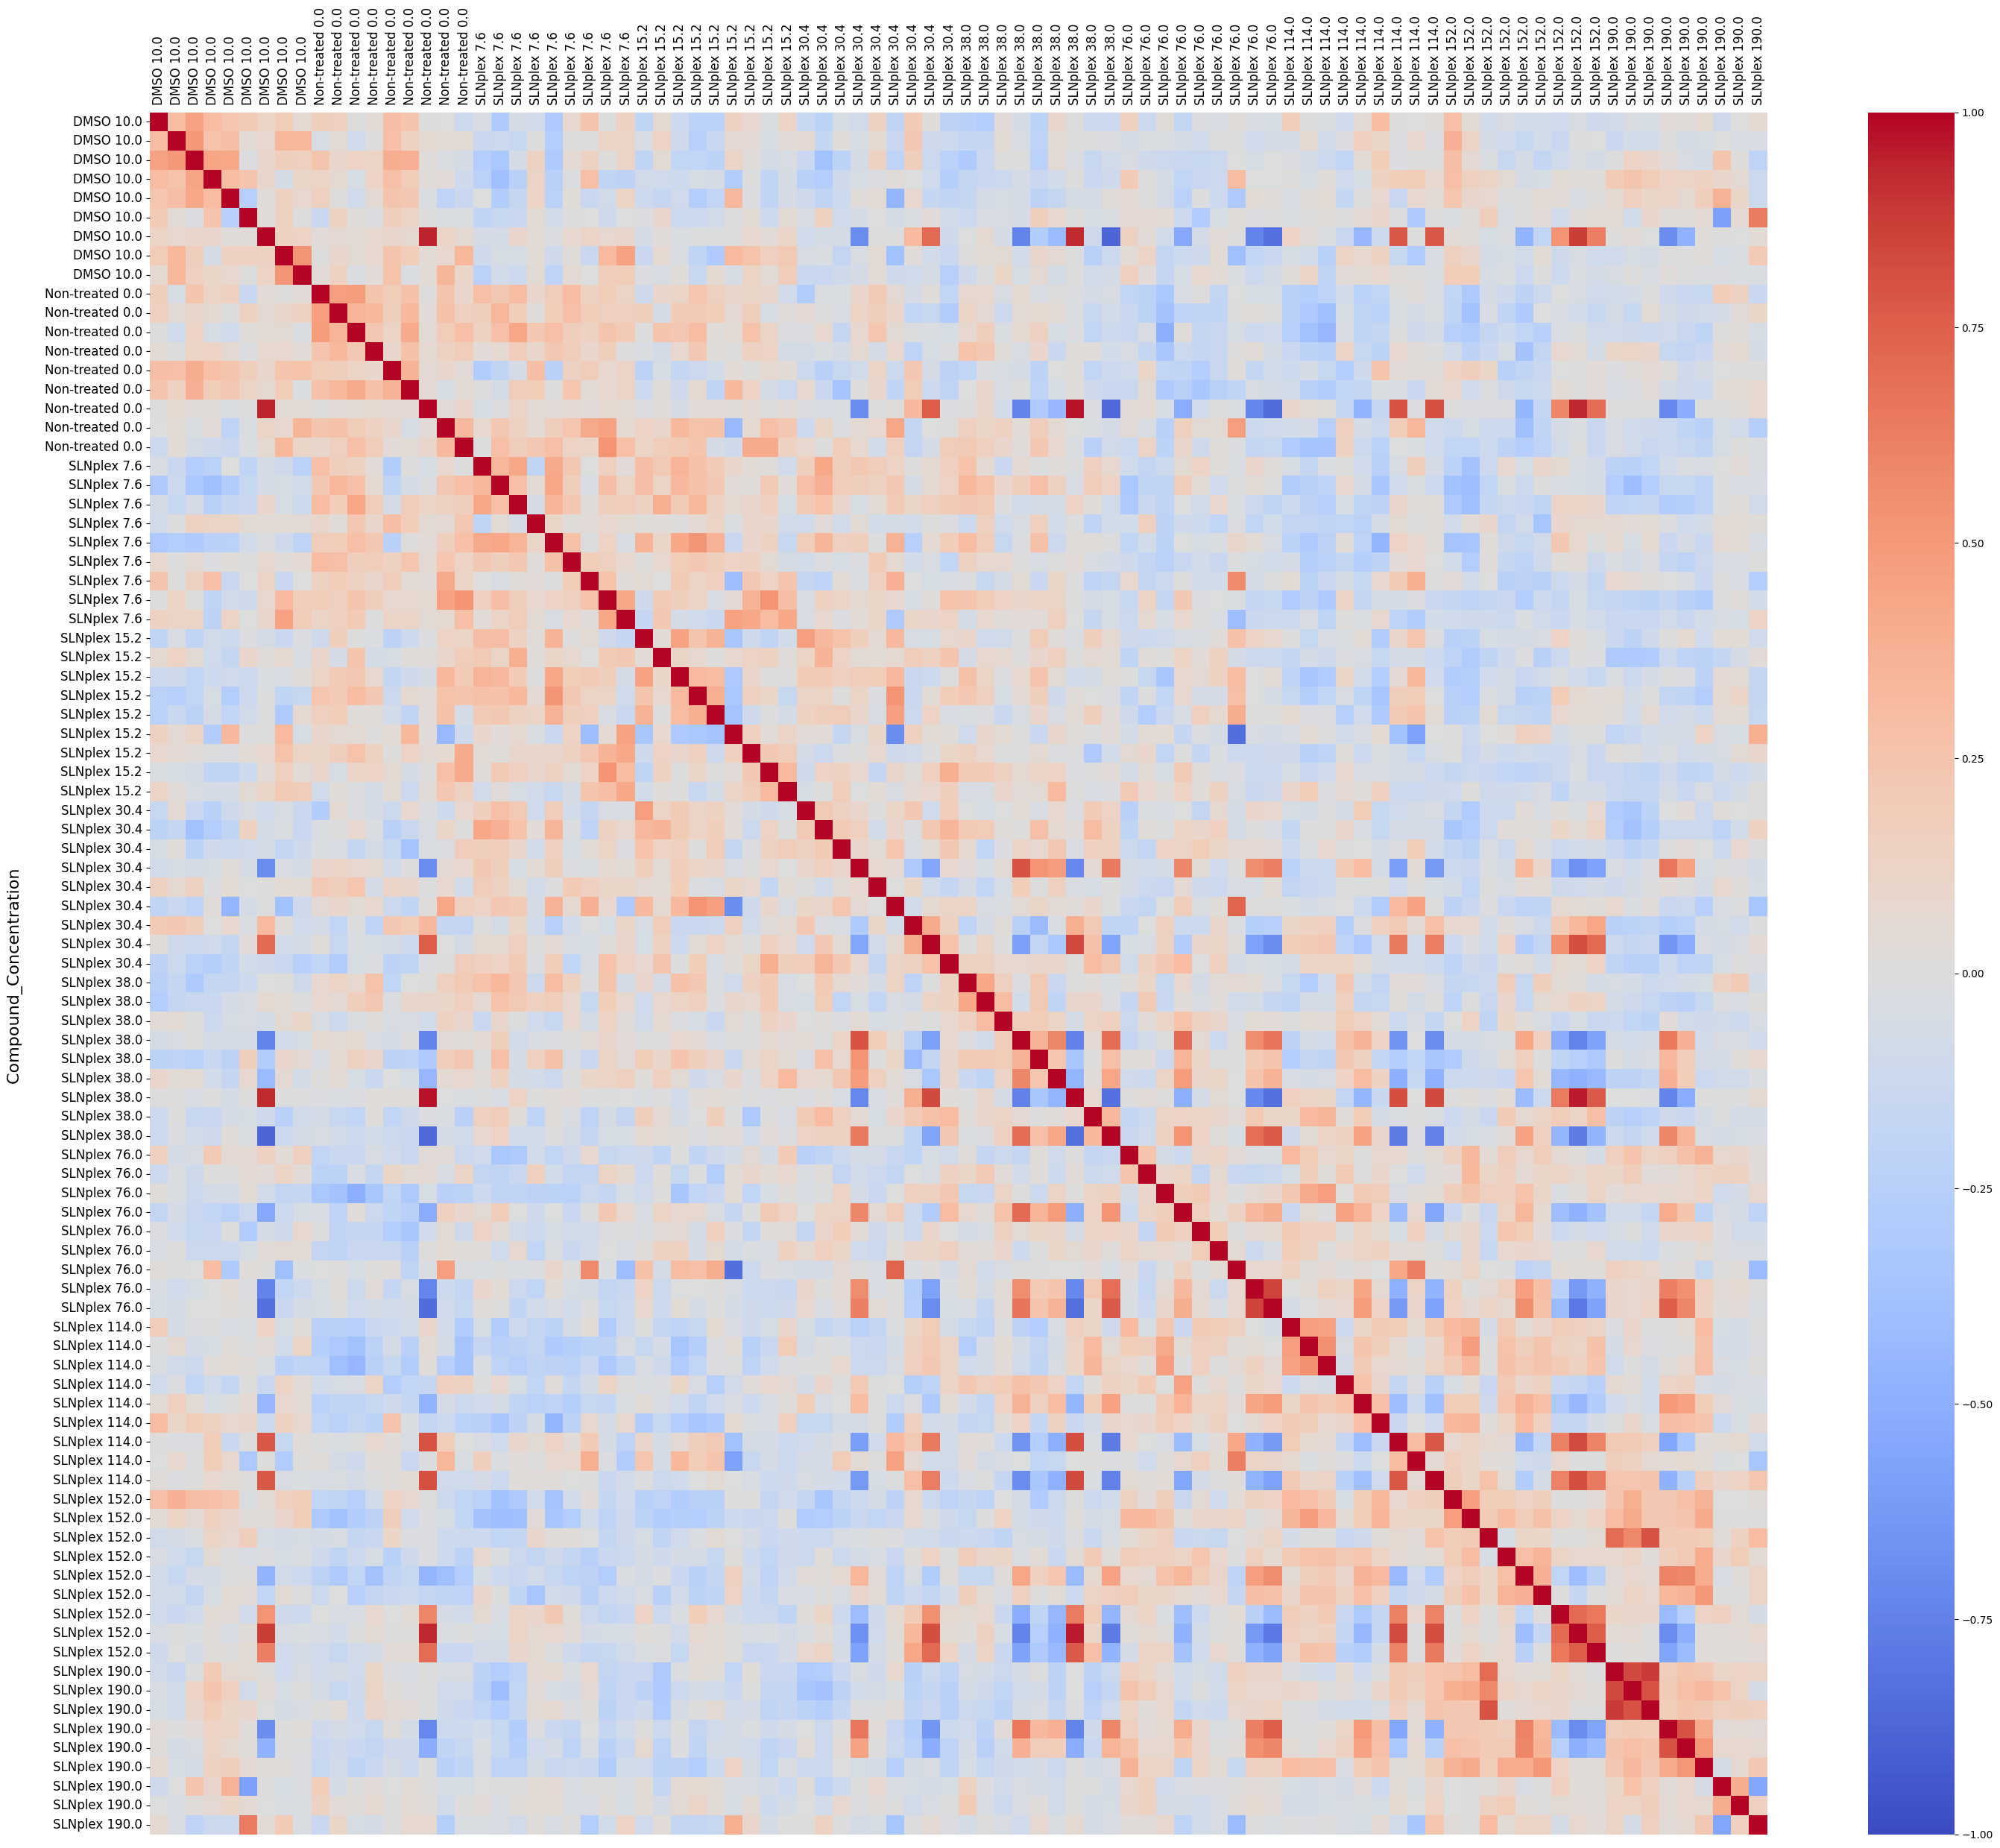

In [11]:
dose_utils.plot_corr_matrix(df_corr, labelsize=12)

## 2.x APPENDIX: Correlation matrix for specific samples

- If you have mixed samples inside one dataframe, which is not ideal, but still if you want to plot those in separate plots, use the following code:

In [ ]:
cmp_unique = ['AgNP 40.0', 'AgNP 100.0'] #define the unique compounds. Each name will generate one matrix

for np in cmp_unique:
    common_list = ['Non-treated 0.0', 'DMSO 0.0'] #define which compounds will be present in all matrices
    input_list = common_list.append(np)
    df_temp = dose_utils.corr_matrix_per_plate(df, plates, plot_joined_replicates=True, metadata_column = new_col,
                                    filter=True, filter_col='Metadata_CompoundSize', filter_list = common_list)
    dose_utils.plot_corr_matrix(df_temp, labelsize=11)

# 3. Dose-response

1) We will generate correlation pairs and dictionaries based on the fact that we have positive controls, negative controls, and treated samples inside your dataframe.

2) Then, we generate a dataframe with the corresponding x and y values:
    
    - x values in log (the concentration of the compound, extracted from `Metadata_Concentration`);
    - y values are the similarity between the replicates of treated samples, including or not the negative control, OR the similarity of the treated samples to the positive control.


3) Plot a linear and non-linear regression. From the non-linear, we get the EC50.


## 3.1 Generate correlation pairs and dictionaries

- All correlations except the diagonal and duplicated values

In [13]:
corr_pairs = dose_utils.correlation_pairs(df_corr)
print('Number of pairs inside one dataframe', len(corr_pairs[0]))

Number of pairs inside one dataframe 4005


## 3.1.1 Dictionaries for each plate

1) Choose the negative control and positive control of your samples;

2) 3 options are available here:


    a) To use the similarity between the replicates of treated samples ONLY:
        ```
        negcon=False
        poscon=False
        ```
    
    b) To use the similarity between the replicates of treated samples AND include the negative control as the beggining of the curve (x = 0):

    **NOTE**: only do that if you DID NOT normalized your data to the negative control. If your data is normalized to the negative control, you should'nt use the negative control to calculate the EC50 curve.
        
        ```
        negcon=True
        poscon=False
        ```

    c) To use the similarity of the treated samples TO the positive control:

    **NOTE**: this is a good option if you have a positive control that has a profile similar to your highest concentration of treatment, which means the similarity between the highest concentration and the positive control will be higher. In this case, the value you get is the IC50 (inhibitory concentration).

        ```
        negcon=False
        poscon=True
        ```

In [14]:
neg_con = eg.choicebox("Select the negative control", "Neg control", df[new_col].unique())
print("Negative control is", neg_con)

In [15]:
pos_con = eg.choicebox("Select the positive control", "Pos control", df[new_col].unique())
print("Positive control is", pos_con)

In [16]:
main_dict = dose_utils.create_dict(corr_pairs, 
                                   list_cmp, 
                                   negcon=False, 
                                   poscon=False, 
                                   negcon_cmp=neg_con, 
                                   poscon_cmp=pos_con)

## 3.2 From dictionaries, generate x, y, x_log to prepare for plot 

In [17]:
df_dict = dose_utils.df_x_y(main_dict, negcon_cmp = neg_con, poscon_cmp = pos_con)
print(df_dict)

[         x     x_log         y          label
0    114.0  4.736198 -0.408829  SLNplex 114.0
1    114.0  4.736198 -0.394956  SLNplex 114.0
2    114.0  4.736198 -0.248965  SLNplex 114.0
3    114.0  4.736198 -0.156884  SLNplex 114.0
4    114.0  4.736198 -0.147149  SLNplex 114.0
..     ...       ...       ...            ...
283   76.0  4.330733  0.202501   SLNplex 76.0
284   76.0  4.330733  0.252068   SLNplex 76.0
285   76.0  4.330733  0.321333   SLNplex 76.0
286   76.0  4.330733  0.392554   SLNplex 76.0
287   76.0  4.330733  0.844006   SLNplex 76.0

[288 rows x 4 columns]]


In [18]:
df_list = dose_utils.df_list_plot(df_dict, plot_joined_replicates=False)

## 3.3 Plot linear regression

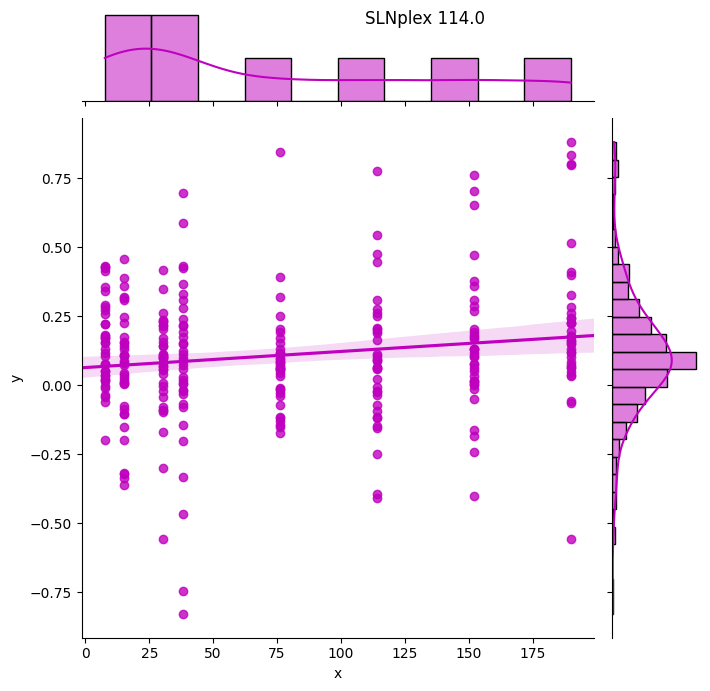

In [19]:
dose_utils.plot_linear_regression(df_list)

## 3.4 Generate non-linear regression plots and calculate EC50 

- Change the values of `ecf` and `hill` to have a initial guess value for the curve.

R-squared: 0.04067971507362733
The EC50 is 162.071 micromolar or 1.6207 mg/mL


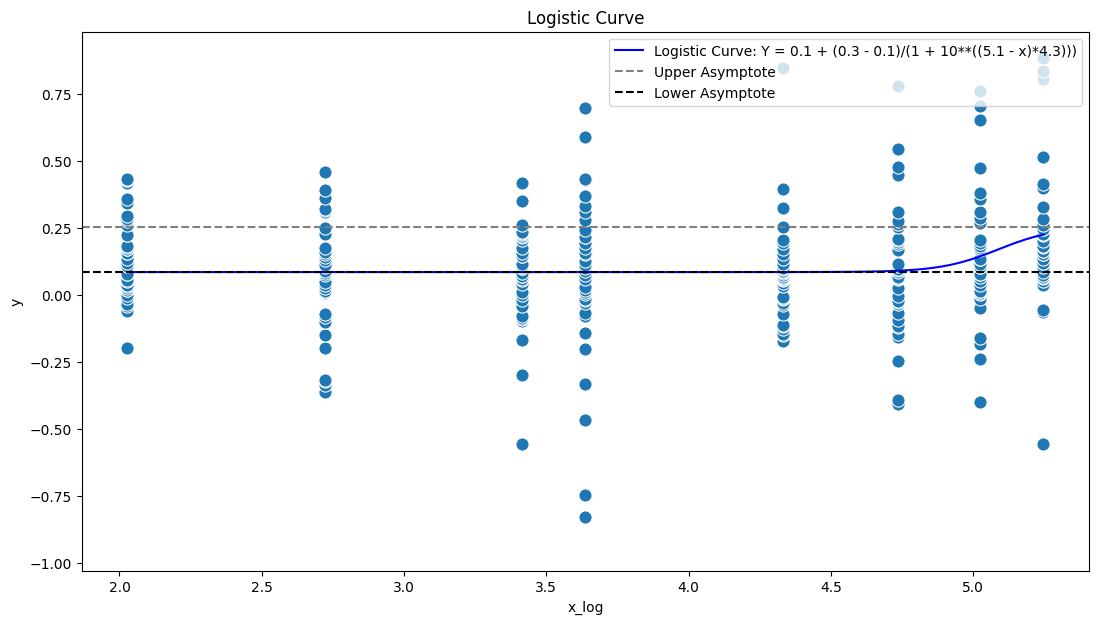

In [21]:
dose_utils.dose_response_generator(df_list, ecf = 10, hill = 10)

# 4. Plot dose-response curve using a chosen feature

- One way to determine which feature have a dose-response effect and that can be useful here is using https://software.broadinstitute.org/morpheus/ to visualize your data and perform a Marker Selection (T-test) between the lowest and highest concentration of your treatments. 

- You will have a list of features that differentiate between those groups.

- Follow the instructions on Basic Protocol 1 to obtain these analysis on Morpheus https://currentprotocols.onlinelibrary.wiley.com/doi/epdf/10.1002/cpz1.713

1) Define the feature you want to fit a logistic regression curve

In [24]:
feature = "Cells_RadialDistribution_RadialCV_AOPI_3of4"

2. The next cells will get the values of the features for each sample and plot

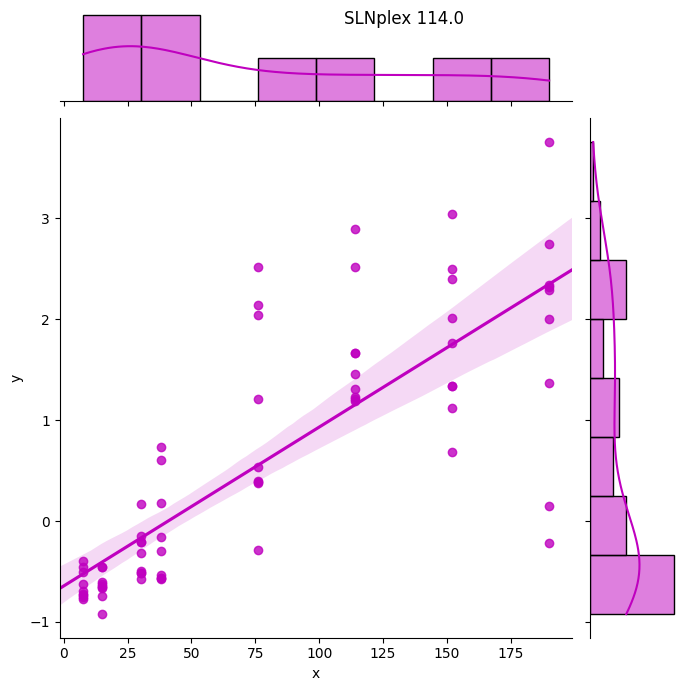

In [25]:
dict_feats = dose_utils.dose_curve_individual_feature(df, 
                                                      list_cmp, 
                                                      feature = feature, 
                                                      label_col = new_col, 
                                                      negcon_cmp = neg_con, 
                                                      poscon_cmp = pos_con)
df_dict = dose_utils.df_x_y(dict_feats)
df_list = dose_utils.df_list_plot(df_dict, plot_joined_replicates=False)
dose_utils.plot_linear_regression(df_list)

3. Run the next to fit the dose response curve. Adjust the **ecf** and **hill** values if necessary.

R-squared: 0.7196837185956788
The EC50 is 61.081 micromolar or 0.6108 mg/mL


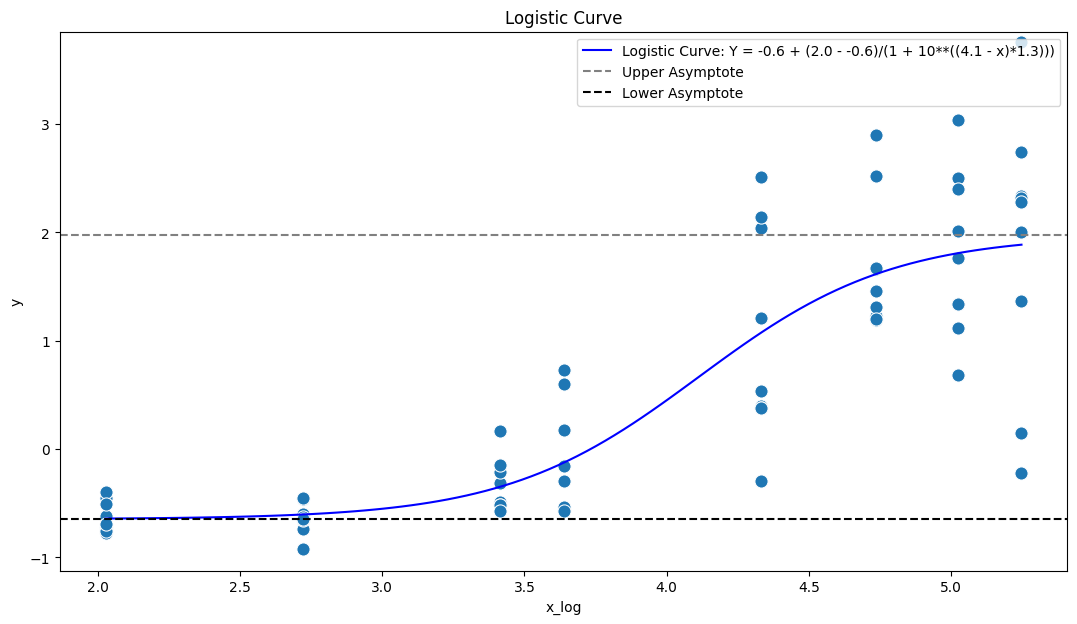

In [27]:
dose_utils.dose_response_generator(df_list, ecf = 10, hill = 10)